# Phân tích sở thích của user đối với item Pega

Tóm tắt

Hướng phân tích:
 - Sự thay đổi tỉ lệ tương tác của các items theo thời gian
 - Các khía cạnh để tìm hiểu sở thích của user qua thời gian theo category và source
 - Các items được tương tác nhiều thường nó có đặc điểm gì thu hút

Kết luận:
 - User click vào bài viết nhiều nhất trong khoảng 30-60 phút bài viết được publish, CTR tăng mạnh sau 120p bài viết được publish.
 - Những tin về Showbiz Việt dù có lượng bài viết đứng thứ 6 nhưng có CTR cao, dẫn đến đây là chuyên mục có lượng user click nhiều thứ 2.
 - Những tuần có thông báo về dịch covid và quyết định giãn cách, cũng là tuần user click nhiều hơn vào các tin thuộc chuyên mục An ninh trật tự
 - User có xu hướng click vào những tin thuộc chuyên mục An ninh trật tự vào đầu tuần và Showbiz Việt vào giữa tuần.
 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('seaborn-deep')
sns.set_style('whitegrid')
from datetime import datetime, timedelta
# pd.options.display.max_rows = 1000
# import plotly.express as pxZ
import random
import plotly.graph_objects as go

In [2]:
cate_pega = pd.read_csv('cate_pega.csv')

In [3]:
origin = pd.read_parquet('origin_0801_1005.parquet.gzip')

In [4]:
origin['pub_timestamp']= [datet.to_pydatetime().timestamp() for datet in origin.publish_date]

In [5]:
origin['pub_timestamp'] = origin['pub_timestamp'].astype(int)

# I, Phân tích tổng quan

# Time decay
Sự thay đổi tỉ lệ tương tác của các items theo thời gian

In [6]:
df_temp = []
df_time = []
time = 60*15
tail1 = 1000
rang = 50
for i in range(rang):
    time1 = (i+1)*time/60
    df_temp2 = origin[origin.event_id == 2].loc[(origin.server_time >= origin.pub_timestamp + i*time) & (origin.server_time < origin.pub_timestamp + (i+1)*time)]\
    .groupby(['item_id','sapo']).count().sort_values('event_id').tail(tail1)[['event_id']].mean()
    df_temp.append(df_temp2.event_id)
    df_time.append(time1)

In [7]:
df_click = pd.DataFrame(data = [df_temp],columns = df_time)

In [8]:
df_temp = []
df_time = []
for i in range(rang):
    time1 = (i+1)*time/60
    df_temp2 = origin[origin.event_id == 14].loc[(origin.server_time >= origin.pub_timestamp + i*time) & (origin.server_time < origin.pub_timestamp + (i+1)*time)]\
    .groupby(['item_id','sapo']).count().sort_values('event_id').tail(tail1)[['event_id']].mean()
    df_temp.append(df_temp2.event_id)
    df_time.append(time1)

In [9]:
df_sapo = pd.DataFrame(data = [df_temp],columns = df_time)

In [10]:
df_temp = []
df_time = []
for i in range(rang):
    time1 = (i+1)*time/60
    df_temp2 = origin[origin.event_id == 22].loc[(origin.server_time >= origin.pub_timestamp + i*time) & (origin.server_time < origin.pub_timestamp + (i+1)*time)]\
    .groupby(['item_id','sapo']).count().sort_values('event_id').tail(tail1)[['event_id']].mean()
    df_temp.append(df_temp2.event_id)
    df_time.append(time1)

In [11]:
df_surf = pd.DataFrame(data = [df_temp],columns = df_time)

In [12]:
decay = df_click.transpose().rename(columns = {0:'click'}).reset_index()\
.merge(df_sapo.transpose().rename(columns = {0:'sapo'}).reset_index(), on = 'index', how = 'inner')\
.merge(df_surf.transpose().rename(columns = {0:'surf'}).reset_index(), on = 'index', how = 'inner').rename(columns = {'index':'minutes'})
decay['CTR'] = decay.click/(decay.click+ decay.surf+ decay.sapo)

<AxesSubplot:xlabel='minutes', ylabel='click'>

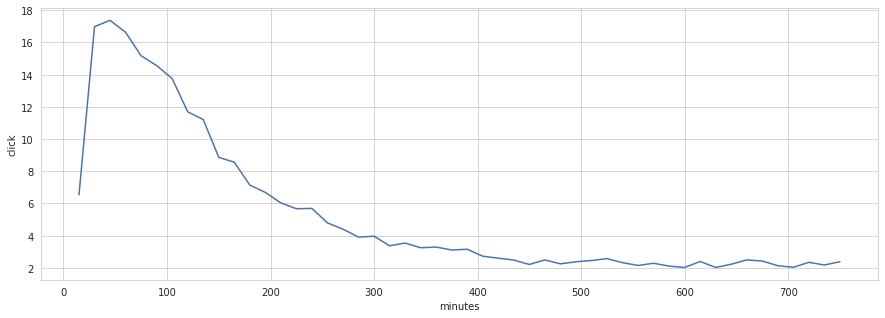

In [13]:
#Phân tích với top 1000 bài viết được user click nhiều nhất
plt.figure(figsize=(15,5))
sns.lineplot(data=decay, 
             x='minutes',y='click')

 - User có xu hướng click vào post nhiều nhất vào khoảng từ 30-45p bài viết được publish với khoảng 17 click/post, rồi sau đó lượng click giảm dần sau 1 tiếng bài viết được publish.
 - Sau khoảng 450 phút, lượng click của mỗi post giao động ổn định trong khoảng 2.5 click/15 phút

<AxesSubplot:xlabel='minutes', ylabel='CTR'>

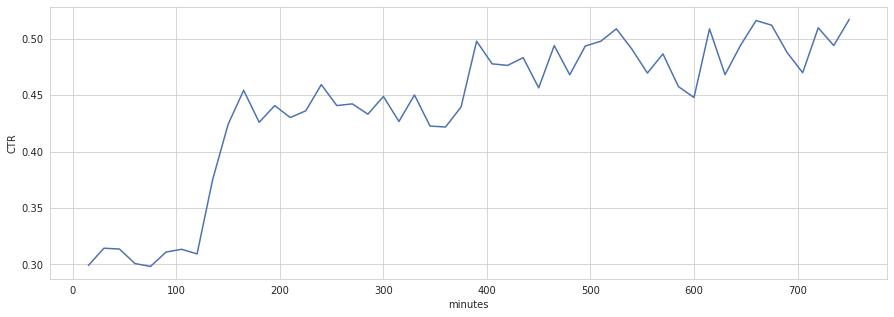

In [14]:
plt.figure(figsize=(15,5))
sns.lineplot(data=decay, 
             x='minutes',y='CTR')

 - Từ 0-120p bài viết được publish CTR của user giao động ổn định trong khoảng 30-32%. Từ 120p-165p CTR có xu hướng tăng đột biết lên khoảng 45%, sau đó CTR có xu hướng tăng nhẹ.
 - Sau 120p, CTR của user tăng trong khi lượng click vào post có xu hướng giảm chứng tỏ ít user tiếp cận với bài viết hơn  nhưng khi có những user tiếp cận họ có tỷ lệ click vào bài viết cao hơn.

# Category
Sở thích của user qua thời gian đối với từng category

In [15]:
origin['date_publish'] = pd.to_datetime(origin.publish_date, format='%y%m%d').dt.date

In [16]:
import datetime
origin['server_date']= [datetime.datetime.fromtimestamp(timestamp).date() for timestamp in origin.server_time.values]

In [17]:
origin = origin.merge(cate_pega, how = 'left', on = 'pega_cate_id')

In [18]:
items_cat = origin.groupby(['name']).nunique()[['item_id']]

In [19]:
click_cat = origin[origin.event_id == 2].groupby(['name']).count()[['event_id']].rename(columns = {'event_id':'click'})

In [20]:
items_click = origin[origin.event_id == 2].groupby(['name']).nunique()[['item_id']].rename(columns = {'item_id':'item_click'})

In [21]:
click_items = click_cat.merge(items_cat, how = 'inner', on = 'name').merge(items_click, how = 'inner', on = 'name')
click_items['click_items'] = click_items.click/click_items.item_id

In [22]:
sapo_cat = origin[origin.event_id == 14].groupby(['name']).count()[['event_id']].rename(columns = {'event_id':'sapo'})

items_sapo = origin[origin.event_id == 14].groupby(['name']).nunique()[['item_id']].rename(columns = {'item_id':'item_sapo'})

sapo_items = sapo_cat.merge(items_cat, how = 'inner', on = 'name').merge(items_sapo, how = 'inner', on = 'name')
sapo_items['sapo_items'] = sapo_items.sapo/sapo_items.item_id

In [23]:
surf_cat = origin[origin.event_id ==22].groupby(['name']).count()[['event_id']].rename(columns = {'event_id':'surf'})

items_surf = origin[origin.event_id == 22].groupby(['name']).nunique()[['item_id']].rename(columns = {'item_id':'item_surf'})

surf_items = surf_cat.merge(items_cat, how = 'inner', on = 'name').merge(items_surf, how = 'inner', on = 'name')
surf_items['surf_items'] = surf_items.surf/surf_items.item_id

In [24]:
items_name = origin.groupby(['name']).nunique()[['item_id']]
click_name = origin[origin.event_id == 2].groupby(['name']).count()[['event_id']].rename(columns = {'event_id':'click'})
items_click = origin[origin.event_id == 2].groupby(['name']).nunique()[['item_id']].rename(columns = {'item_id':'item_click'})
click_items = click_name.merge\
(items_name, how = 'inner', on = 'name').merge(items_click, how = 'inner', on = 'name')
click_items['click_items'] = click_items.click/click_items.item_id
sapo_name = origin[origin.event_id == 14].groupby(['name']).count()[['event_id']].rename(columns = {'event_id':'sapo'})
items_sapo = origin[origin.event_id == 14].groupby(['name']).nunique()[['item_id']].rename(columns = {'item_id':'item_sapo'})
sapo_items = sapo_name.merge(items_name, how = 'inner', on = 'name').merge(items_sapo, how = 'inner', on = 'name')
sapo_items['sapo_items'] = sapo_items.sapo/sapo_items.item_id
surf_name = origin[origin.event_id ==22].groupby(['name']).count()[['event_id']].rename(columns = {'event_id':'surf'})
items_surf = origin[origin.event_id == 22].groupby(['name']).nunique()[['item_id']].rename(columns = {'item_id':'item_surf'})
surf_items = surf_name.merge(items_name, how = 'inner', on = 'name').merge(items_surf, how = 'inner', on = 'name')
surf_items['surf_items'] = surf_items.surf/surf_items.item_id
name_df = click_items.merge(sapo_items , how = 'inner', on = ['name','item_id']).merge(surf_items , how = 'inner', on = ['name','item_id'])
name_df['CTR'] = name_df.click/(name_df.sapo + name_df.surf+name_df.click)
name_df['Read_sapo_rate'] = name_df.sapo/(name_df.sapo + name_df.surf+name_df.click)
name_df['clicked_items'] = name_df.item_click/name_df.item_id

In [25]:
cat_df = click_items.merge(sapo_items , how = 'inner', on = ['name','item_id']).merge(surf_items , how = 'inner', on = ['name','item_id'])

In [26]:
cat_df['CTR'] = cat_df.click/(cat_df.sapo + cat_df.surf+cat_df.click)
cat_df['Read_sapo_rate'] = cat_df.sapo/(cat_df.sapo + cat_df.surf+cat_df.click)
cat_df['clicked_items'] = cat_df.item_click/cat_df.item_id

In [29]:
cat_df

click  item_id  item_click  click_items   sapo  \
name                                                                    
An ninh trật tự        75506    21863        8995     3.453597  45249   
Showbiz Việt           71016    12226        5769     5.808605  23653   
Xã hội                 48922    19599        6784     2.496148  37420   
Thế giới               35774    20305        6832     1.761832  48984   
Bóng đá                18134    17615        4492     1.029464  17487   
Thị trường             14390    15564        3505     0.924570  22834   
Tình yêu               13815     1635        1042     8.449541   4798   
Các bệnh thường gặp    13551     3630        1658     3.733058   6383   
Bất động sản           12780     8296        2484     1.540501  12595   
Nóng trên mạng         10945     1043         571    10.493768   2508   
Âm nhạc                 9696     2072         554     4.679537   8280   
Quân sự                 7341     4049        1383     1.813040   4751   
Bên lề Thể thao         7269     8118        2085     0.895418   7849   
Điện ảnh                5444     5147        1721     1.057704   6930   
Ô tô xe máy             5352     3750        1138     1.427200   4559   
Thế giới doanh nhân     4078     1250         388     3.262400   1721   
Tài chính - ngân hàng   3912     4937        1140     0.792384  11391   
Du lịch                 3419     1843         450     1.855128   2514   
Game                    3349     1269         305     2.639086   1375   
Nuôi con                3057      961         454     3.181061   2078   

                       item_sapo  sapo_items    surf  item_surf  surf_items  \
name                                                                          
An ninh trật tự            15588    2.069661  306052      21537   13.998628   
Showbiz Việt                8689    1.934647  134206      12114   10.977098   
Xã hội                     14334    1.909281  237116      19450   12.098372   
Thế giới                   13665    2.412411  222821      20134   10.973701   
Bóng đá                     9437    0.992733  118048      17354    6.701561   
Thị trường                 10112    1.467104  141798      15448    9.110640   
Tình yêu                    1352    2.934557   17672       1607   10.808563   
Các bệnh thường gặp         2603    1.758402   43863       3571   12.083471   
Bất động sản                5410    1.518202   76615       8213    9.235174   
Nóng trên mạng               832    2.404602   15850       1029   15.196548   
Âm nhạc                     1151    3.996139   19573       2037    9.446429   
Quân sự                     2391    1.173376   34851       3938    8.607310   
Bên lề Thể thao             4347    0.966864   52777       8013    6.501232   
Điện ảnh                    3199    1.346415   31464       5076    6.113076   
Ô tô xe máy                 2204    1.215733   24840       3694    6.624000   
Thế giới doanh nhân          775    1.376800   10443       1240    8.354400   
Tài chính - ngân hàng       2710    2.307272   41825       4891    8.471744   
Du lịch                     1188    1.364080   16092       1819    8.731416   
Game                         659    1.083530    9459       1246    7.453901   
Nuôi con                     703    2.162331    9208        941    9.581686   

                            CTR  Read_sapo_rate  clicked_items  
name                                                            
An ninh trật tự        0.176909        0.106017       0.411426  
Showbiz Việt           0.310283        0.103345       0.471863  
Xã hội                 0.151247        0.115687       0.346140  
Thế giới               0.116308        0.159257       0.336469  
Bóng đá                0.118007        0.113797       0.255010  
Thị trường             0.080381        0.127549       0.225199  
Tình yêu               0.380736        0.132231       0.637309  
Các bệnh thường gặp    0.212408        0.100052       0.456749  
Bất động sản           0.12

In [30]:
cat_df = cat_df.sort_values('click',ascending = False).reset_index()
cat_dff = cat_df

### Tổng quan

In [ ]:
cat_df = cat_df.iloc[:20]
fig,ax = plt.subplots(figsize = (18, 10))
plt.title ('Sent & Seen rate by Group of Pega', fontsize = 20)
plt.xticks(rotation=70, ha='right',fontsize = 14)
ax.bar(cat_df.name,'click', data=cat_df, color="firebrick")
ax.yaxis.grid(True)
ax.set_xlabel("Customer Classification Group",fontsize=18)
ax.set_ylabel("Sent_count",color="red",fontsize=18)
ax.set_ylim()
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(cat_df.name,'CTR', data=cat_df,color="blue",marker="o")
ax2.set_ylabel("Seen_rate",color="blue",fontsize=18,rotation=270)
ax2.set_ylim(0,1)
ax2.legend(loc='upper right',fontsize=14)

plt.show()

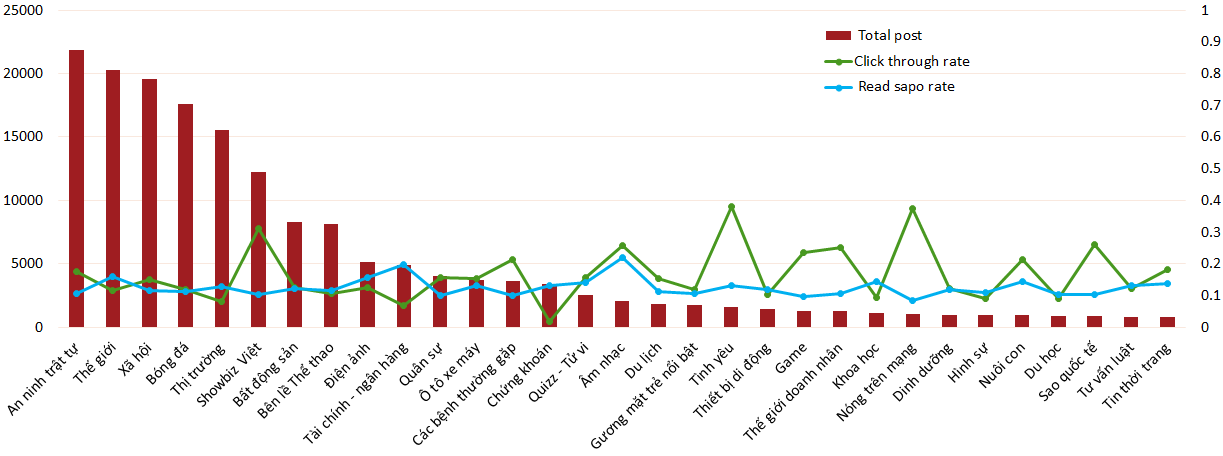

 - An ninh trật tự là category có nhiều bài viết nhất và CTR cũng đạt mức khá cao, vì vậy đây là chuyên mục được user click vào nhiều nhất.
 - Những tin về Showbiz Việt dù có lượng bài viết đứng thứ 6 nhưng có CTR cao, dẫn đến đây là chuyên mục có lượng user click nhiều thứ 2, nên tăng cường số post về category này.
 - Tình yêu và Nóng trên mạng là 2 chuyên mục có CTR cao nhất trong 2 tháng qua.
 - Thế giới, Tài chính và Chứng khoán là các chuyên mục có tỷ lệ user dừng lại đọc sapo khá cao nhưng lại ít click vào.
 - Âm nhạc là chuyên mục có tỷ lệ user read sapo cao nhất và đồng thời cũng có CTR khá cao

In [32]:
origin.server_date = pd.to_datetime(origin.server_date, errors='coerce')

In [33]:
origin.date_publish = pd.to_datetime(origin.date_publish, errors='coerce')

In [34]:
origin['publish_day']=origin.date_publish.dt.day_name()

In [35]:
origin['server_day']=origin.server_date.dt.day_name()

In [36]:
origin['week'] = origin.server_date.dt.strftime("%V")

In [37]:
cat_week = origin[origin.event_id == 2].groupby(['week','name']).count()[['event_id']].reset_index().sort_values('event_id', ascending = False)\
.merge(origin[origin.event_id == 2].groupby(['week','name']).nunique()[['sapo']].reset_index().sort_values('sapo', ascending = False), on = ['week','name'], how = 'inner')
cat_week['CTR'] = cat_week.event_id/cat_week.sapo

In [38]:
pivot_week = cat_week.sort_values('event_id', ascending = False)\
.pivot_table(values='CTR', index=['name'],columns=['week'])#.reset_index()

### User đang quan tâm đến category nào theo tuần
Phân tích sâu vào 4 chuyên mục có sản lượng bài viết nhiều nhất

In [39]:
pivot_cat = origin[origin.event_id == 2].groupby(['name', 'server_day']).count()[['event_id']].reset_index().pivot_table(values='event_id', index=['name'],
                     columns=['server_day']).sort_values('Friday',ascending = False)#.reset_index(drop=True, inplace=True)

In [40]:
pivot_cat = pivot_cat.transpose()
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_cat = pivot_cat.reindex(cats)
pivot_cat = pivot_cat.transpose()

In [41]:
week_pivot = pivot_week.merge(pivot_cat.iloc[:10].Friday, on = 'name' , how = 'inner').sort_values('Friday', ascending = False).drop(columns = {'Friday'})

In [42]:
week_cat = cat_week.sort_values('event_id', ascending = False)\
.pivot_table(values='event_id', index=['name'],columns=['week']).sort_values('38', ascending = False)#.reset_index()


Text(0.5, 1.0, 'Tổng lượt click vào các category theo tuần')

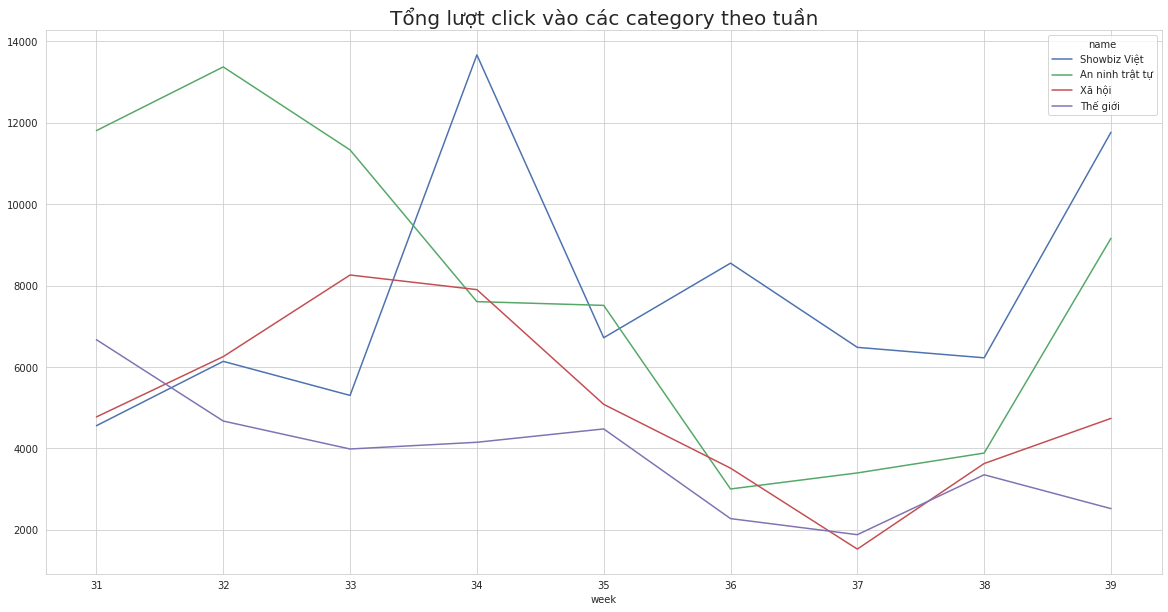

In [43]:
df_stable = week_cat.iloc[:4].drop(columns = {'30','40'})
df_stable
df_stable.transpose().plot (kind = 'line', figsize = (20, 10))
plt.title ( 'Tổng lượt click vào các category theo tuần', fontsize = 20)

- Tuần thứ 32 (từ 02/08 - 08/08) là tuần user click bào tin thuộc chuyên mục An ninh trật tự nhiều nhất, đây cũng là tuần bắt đầu có chỉ thị dãn cách do Covid tại Hà Nội. Sau đó lượng click vào tin thuộc chuyên mục này có xu hướng giảm mạnh cho đến khi tăng mạnh trở lại vào Tuần thứ 39, cũng là tuần có thông báo bắt đầu mở cửa trở lại sao 2 tháng dãn cách.
- Showbiz Việt là category được user quan tâm nhiều nhất trong khoảng thời gian từ tuần 34 - 39. Mặc dù chỉ có lượng bài viết đứng thứ 6 trong vòng 2 tháng qua.

In [ ]:
df_stable = week_pivot.iloc[:4].drop(columns = {'30','40'})
df_stable
df_stable.transpose().plot (kind = 'line', figsize = (20, 10))
plt.title ('Lượt click/post vào các category theo tuần', fontsize = 20)

 - Trong suốt 2 tháng, Showbiz Việt luôn là category có lượng user click trung bình nhiều nhất với trung bình khoảng 12 click/post.
 - Tổng lượng click nhiều của mục An ninh trật tự có thể là do chuyên mục này có lượng bài viết lớn.

### User đang quan tâm đến category nào theo các ngày trong tuần

Text(0.5, 1.0, 'tổng lượng click vào các category theo ngày trong tuần')

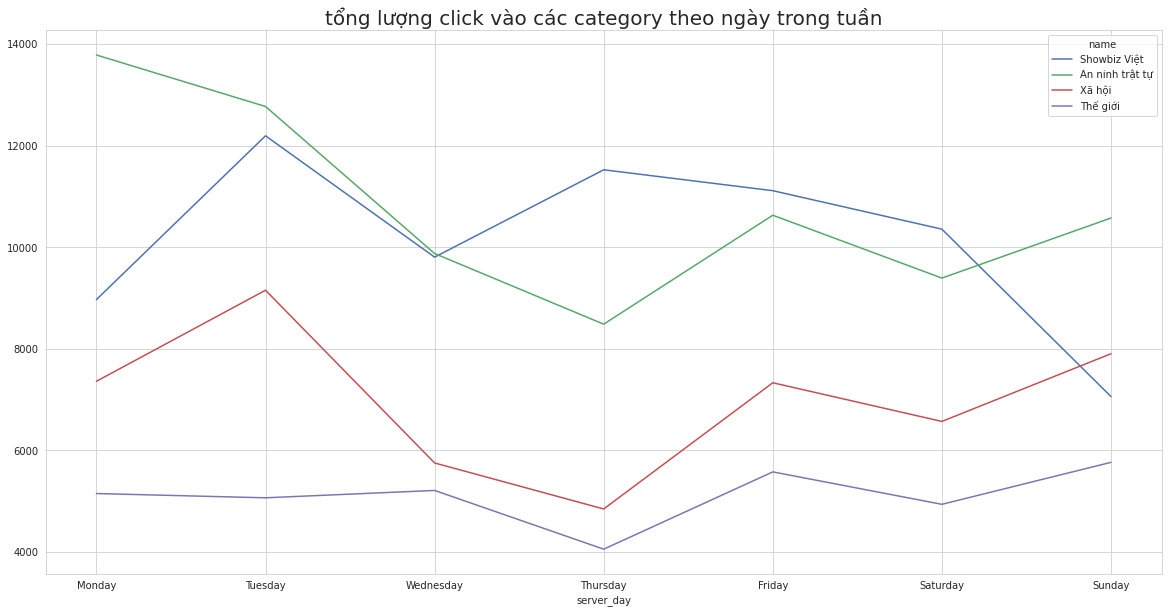

In [71]:
df_stable = pivot_cat.iloc[:4]
df_stable
df_stable.transpose().plot (kind = 'line', figsize = (20, 10))
plt.title ('tổng lượng click vào các category theo ngày trong tuần', fontsize = 20)

 - Những tin thuộc mục An ninh trật tự được user click nhiều nhất vào 2 ngày đầu tuần, sau đó lượng click giảm dần và giao động ổn định vào các ngày giữa tuần và cuối tuần.
 - User quan tâm đến những tin thuộc category showbiz Việt nhiều nhất vào thứ 3 và thứ 5. Thứ 5 cũng là ngày các chuyên mục khác có lượng click thấp nhất trong tuần nói lên user khá quan tâm đến tin về Showbiz Việt vào ngày này trong tuần.
 - Chủ nhật là ngày lượng click về các tin thuộc An ninh trật tự, xã hội và thế giới có xu hướng tăng, riêng tin về Showbiz Việt có xu hướng giảm.

In [72]:
cat_pivot = origin[origin.event_id == 2].groupby(['name', 'server_day']).count()[['event_id']].rename(columns= {'event_id': 'click'})\
.merge(origin[origin.event_id == 14].groupby(['name', 'server_day']).count()[['event_id']].rename(columns= {'event_id': 'sapo'}), how = 'inner',on = ['name','server_day'])\
.merge(origin[origin.event_id == 22].groupby(['name', 'server_day']).count()[['event_id']].rename(columns= {'event_id': 'surf'}), how = 'inner',on = ['name','server_day'])

In [73]:
source_df['CTR'] = source_df.click/(source_df.sapo + source_df.surf+source_df.click)
source_df['Read_sapo_rate'] = source_df.sapo/(source_df.sapo + source_df.surf+source_df.click)
source_df['clicked_items'] = source_df.item_click/source_df.item_id

click  item_id  item_click  click_items   sapo  \
source                                                                 
vtv4.vtv.vn               1       24           1     0.041667      3   
htv.com.vn                2       22           2     0.090909     11   
ngaymoionline.com.vn      2        7           2     0.285714      9   
nhadat.tuoitre.vn         3       15           3     0.200000     14   
afamily.vn                5        1           1     5.000000      6   
...                     ...      ...         ...          ...    ...   
2sao.vn               22628     2888        1496     7.835180   5387   
tuoitre.vn            30764     5452        2229     5.642700   9768   
AFamily               46198     3981        2399    11.604622   9021   
Soha                  64709     4832        3114    13.391763  16586   
Kenh14                71719     3372        2152    21.268980   7604   

                      item_sapo  sapo_items   surf  item_surf  surf_items  \
source                                                                      
vtv4.vtv.vn                   3    0.125000     25         19    1.041667   
htv.com.vn                    8    0.500000     67         22    3.045455   
ngaymoionline.com.vn          4    1.285714     62          7    8.857143   
nhadat.tuoitre.vn             9    0.933333     66         14    4.400000   
afamily.vn                    1    6.000000     21          1   21.000000   
...                         ...         ...    ...        ...         ...   
2sao.vn                    2041    1.865305  38486       2839   13.326177   
tuoitre.vn                 3869    1.791636  79386       5393   14.560895   
AFamily                    2933    2.266014  61532       3927   15.456418   
Soha                       3446    3.432533  98199       4730   20.322641   
Kenh14                     2508    2.255042  72704       3309   21.561091   

                           CTR  Read_sapo_rate  clicked_items  
source                                                         
vtv4.vtv.vn           0.034483        0.103448       0.041667  
htv.com.vn            0.025000        0.137500       0.090909  
ngaymoionline.com.vn  0.027397        0.123288       0.285714  
nhadat.tuoitre.vn     0.036145        0.168675       0.200000  
afamily.vn            0.156250        0.187500       1.000000  
...                        ...             ...            ...  
2sao.vn               0.340266        0.081006       0.518006  
tuoitre.vn            0.256542        0.081456       0.408841  
AFamily               0.395697        0.077267       0.602612  
Soha                  0.360508        0.092404       0.644454  
Kenh14                0.471752        0.050017       0.638197  

[96 rows x 13 columns]

In [74]:
cat_pivot['CTR'] = cat_pivot.click/(cat_pivot.sapo + cat_pivot.surf+cat_pivot.click)
cat_pivot['Read_sapo_rate'] = cat_pivot.sapo/(cat_pivot.sapo + cat_pivot.surf+cat_pivot.click)

In [75]:
pivot_cate = cat_pivot.reset_index().pivot_table(values='CTR', index=['name'],
                     columns=['server_day'])#.sort_values('Friday',ascending = False)#.reset_index(drop=True, inplace=True)

In [76]:
pivot_cate = pivot_cate.transpose()
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_cate = pivot_cate.reindex(cats)
pivot_cate = pivot_cate.transpose()

# Các items được tương tác nhiều thường nó có đặc điểm gì thu hút

In [ ]:
norigin = origin.drop(columns = {'title_token','sapo_token','aspect_id', 'trend_id','id','description'})

In [ ]:
top_100 = origin[origin.event_id == 2].groupby(['item_id','sapo','name','tags','title_ner','sapo_postag'])\
.count()[['event_id']].sort_values('event_id',ascending = False).head(200)

### Top 20 bài viết được click nhiều nhất

In [ ]:
origin[origin.event_id == 2].groupby(['sapo','name']).count()[['event_id']].sort_values('event_id',ascending = False).head(20).rename(columns = {'event_id':'click'})

- Các post được nhiều click thường có tên riêng của những người nổi tiếng và thường thuộc category Showbiz việt

### Các từ khóa hấp dẫn user click nhất 
Tính trong top 200 bài viết được click nhiều nhất

In [ ]:
#title_ner
from wordcloud import WordCloud
plt.figure( figsize=(20,10) )

wc=WordCloud(background_color='white',colormap='RdBu',width=1500, height=700)\
.generate_from_frequencies(pd.DataFrame(top_100.reset_index().title_ner.str.split(' ',13, expand=True)\
                                        .stack().reset_index().dropna(0)[0].dropna().to_list()).reset_index().groupby(0).count()['index'].to_dict())

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.imshow(wc)

### Các tags hấp dẫn user click nhất 

In [ ]:
from wordcloud import WordCloud
plt.figure( figsize=(20,10) )

wc=WordCloud(background_color='white',colormap='RdBu',width=1500, height=700)\
.generate_from_frequencies(pd.DataFrame(top_100.reset_index().tags.str.split(';',13, expand=True).stack().reset_index()\
                                        .dropna(0)[0].dropna().to_list()).reset_index().groupby(0).count()['index'].to_dict())

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.imshow(wc)

### Source nào được user quan tâm nhất nhiều nhất

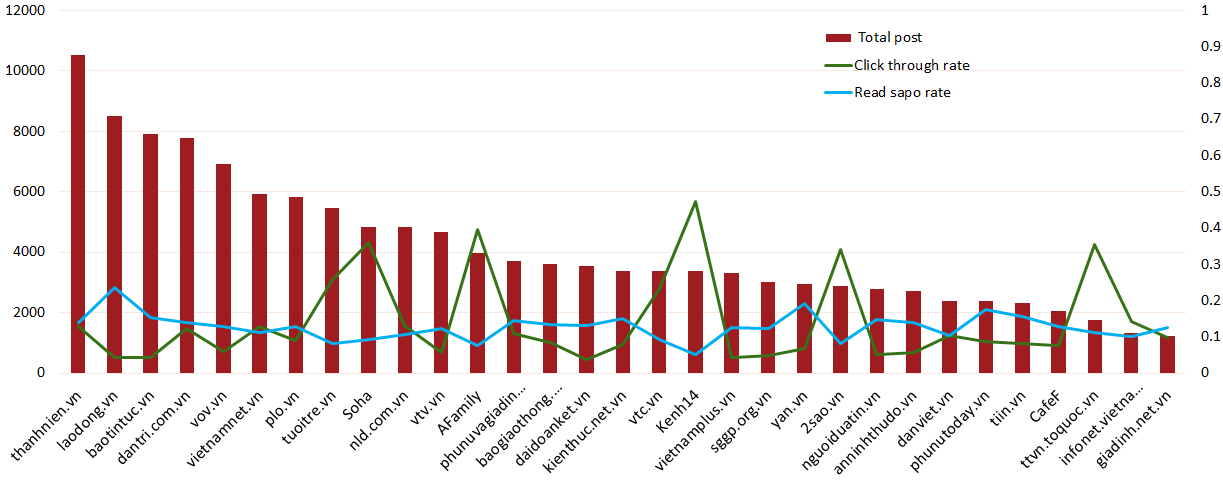

 - Kênh 14, Afamily, Soha và 2sao là các source có CTR cao nhất, đồng thời đây cũng là những source mang lại lượng click nhiều nhất cho Pega dù có lượng post không phải là cao nhất
 - User thường có xu hướng chỉ đọc sapo mà ít click vào những tin thuộc báo Lao động.

In [ ]:
source_df.sort_values('click', ascending = False).head(30)[['click','click_items']].rename(columns = {'click_items' : 'click/post'})

In [100]:
pivot_user = origin.groupby(['device_id','name','event_id' ,pd.Grouper(key='server_date', freq='2D')]).count()[['item_id']]\
.reset_index().pivot_table(values='item_id', index=['device_id','name','server_date'],columns=['event_id']).reset_index()\
.rename(columns = {2:'click', 4 : 'close', 14 : 'sapo', 22:'surf'}).fillna(0)
pivot_user['CTR'] = pivot_user.click/(pivot_user.click+ pivot_user.sapo+ pivot_user.surf)

In [101]:
click_user = origin[origin.event_id == 2].groupby(['device_id','name','server_date']).count()[['item_id']].rename(columns = {'item_id':'click'}).reset_index()
sapo_user = origin[origin.event_id == 14].groupby(['device_id','name','server_date']).count()[['item_id']].rename(columns = {'item_id':'sapo'}).reset_index()
surf_user = origin[origin.event_id == 22].groupby(['device_id','name','server_date']).count()[['item_id']].rename(columns = {'item_id':'surf'}).reset_index()

# II, Phân tích cá nhân hóa

In [102]:
user_active = pivot_user.dropna(subset=['click']).groupby('device_id').sum().reset_index().sort_values('click', ascending = False)[['device_id']].reset_index()#[['device_id']]

In [103]:
for i in range(100):
    globals()['user_%s' % i] = pivot_user[pivot_user.device_id == user_active.device_id[i]]#.pivot_table(values='CTR', index=['device_id','name'],columns=['server_date'])
    globals()['cat_user_%s' % i] = origin[origin.device_id == globals()['user_%s' % i].reset_index().device_id[0]]\
    .drop(columns = {'is_temp', 'following_cate','following_site','content_type','description','publish_day','title_token','sapo_token','aspect_id', 'trend_id','id' })


In [106]:
all_user = user_0[['name','server_date','CTR']].rename(columns = {'CTR':f'user_0'})
for i in range(1,100):
    all_user = all_user.merge(globals()['user_%s' % i][['name','server_date','CTR']].rename(columns = {'CTR':f'user_{i}'})
                   ,on=['name','server_date'], how='outer')

In [107]:
std = all_user.set_index(['server_date']).drop(columns = {'name'}).transpose().std()

In [108]:
all_user['std'] = std.tolist()

## Quan sát CTR của một số user qua thời gian

### Category ANTT

<AxesSubplot:xlabel='server_date', ylabel='CTR'>

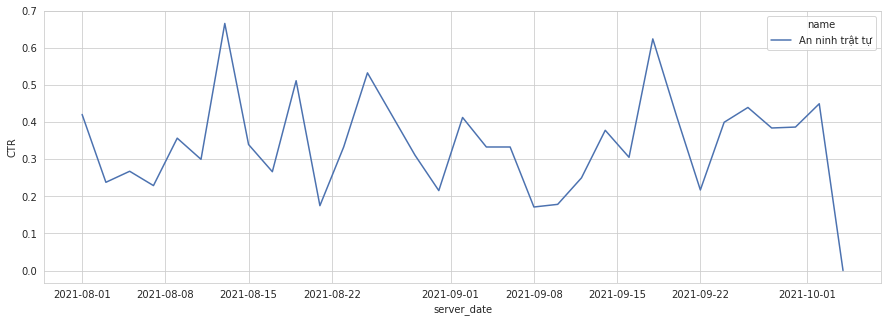

In [109]:
plt.figure(figsize=(15,5))
sns.lineplot(data=user_1[user_1.name == 'An ninh trật tự'], 
             x='server_date',y='CTR', hue = 'name')

<AxesSubplot:xlabel='server_date', ylabel='CTR'>

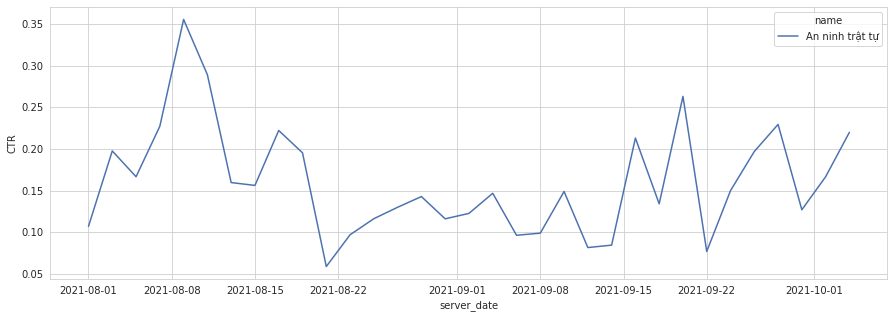

In [110]:
plt.figure(figsize=(15,5))
sns.lineplot(data=user_2[user_2.name == 'An ninh trật tự'], 
             x='server_date',y='CTR', hue = 'name')

<AxesSubplot:xlabel='server_date', ylabel='CTR'>

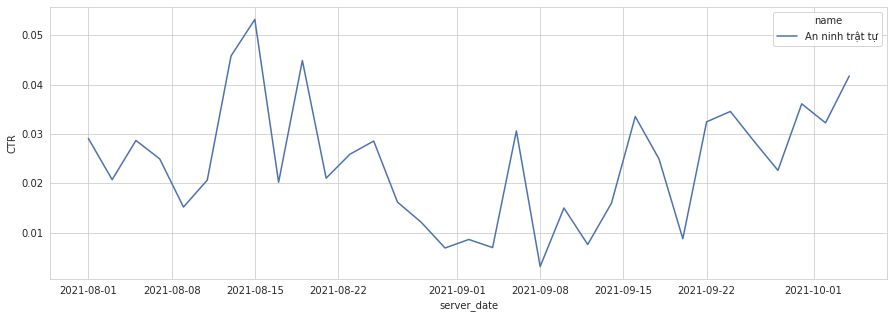

In [111]:
plt.figure(figsize=(15,5))
sns.lineplot(data=user_3[user_3.name == 'An ninh trật tự'], 
             x='server_date',y='CTR', hue = 'name')

<AxesSubplot:xlabel='server_date', ylabel='CTR'>

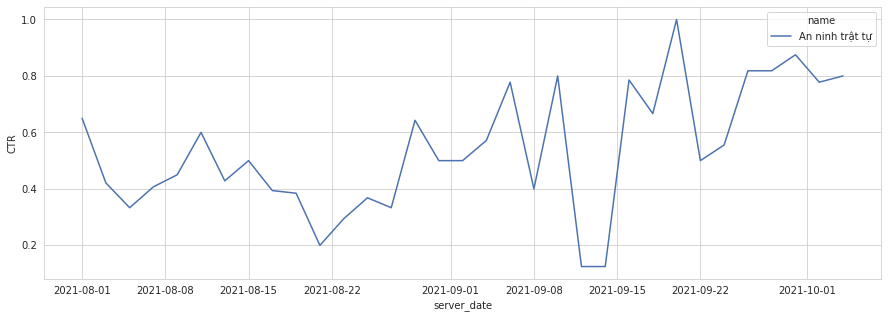

In [112]:
plt.figure(figsize=(15,5))
sns.lineplot(data=user_5[user_5.name == 'An ninh trật tự'], 
             x='server_date',y='CTR', hue = 'name')

 - Một số user tương tác với cat ANTT có xu hướng CTR khá giống nhau, đều giảm vào cuối tháng 8 và đầu tháng 9 rồi sau đó tăng lại, giống với xu hướng chung của từng tuần đã phân tích ở trên. 
 - Nhưng có thể là do đặc thù chuyên mục chứ không phải do các user này có sở thích gần giống nhau, cần thử phân tích thêm các chuyên mục khác để đánh giá rõ ràng hơn.

### Showbiz Việt

<AxesSubplot:xlabel='server_date', ylabel='CTR'>

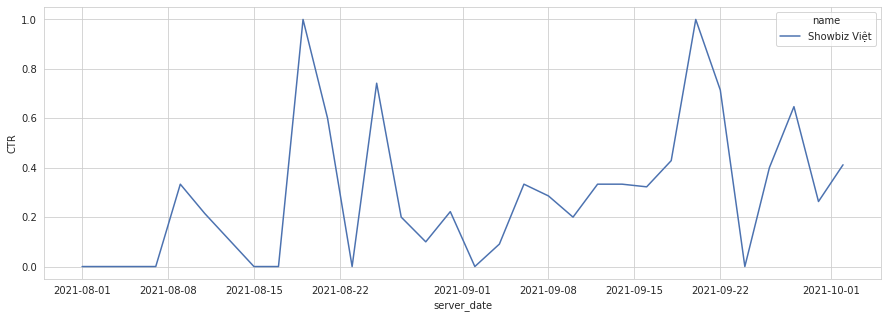

In [113]:
# 3 user click nhiều
plt.figure(figsize=(15,5))
sns.lineplot(data=user_1[user_1.name == 'Showbiz Việt'], 
             x='server_date',y='CTR', hue = 'name')

<AxesSubplot:xlabel='server_date', ylabel='CTR'>

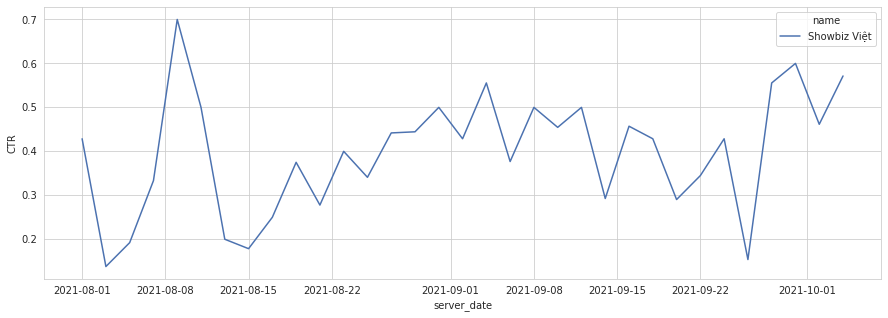

In [114]:
plt.figure(figsize=(15,5))
sns.lineplot(data=user_2[user_2.name == 'Showbiz Việt'], 
             x='server_date',y='CTR', hue = 'name')

<AxesSubplot:xlabel='server_date', ylabel='CTR'>

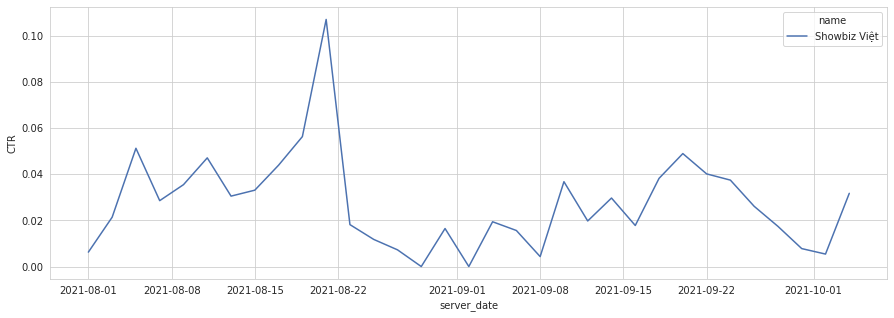

In [115]:
plt.figure(figsize=(15,5))
sns.lineplot(data=user_3[user_3.name == 'Showbiz Việt'], 
             x='server_date',y='CTR', hue = 'name')

### Sau khi quan sát:
- Có thể nhìn thấy khá rõ khác biệt CTR của những user này qua từng ngày. Vì vậy, có thể có sự khác biệt về sở thích giữa các user khi click vào các bài viết thuộc cat Showbiz Việt
- Cần phân tích sâu hơn về nhóm user này

<AxesSubplot:xlabel='server_date', ylabel='CTR'>

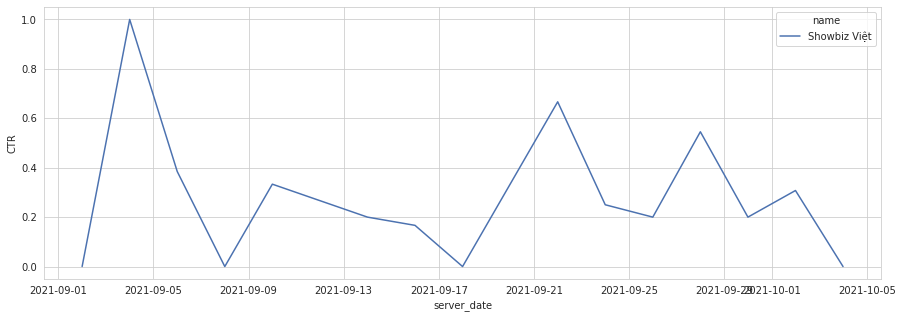

In [116]:
# quan sát thêm 2 user ít click
plt.figure(figsize=(15,5))
sns.lineplot(data=user_99[user_99.name == 'Showbiz Việt'], 
             x='server_date',y='CTR', hue = 'name')

<AxesSubplot:xlabel='server_date', ylabel='CTR'>

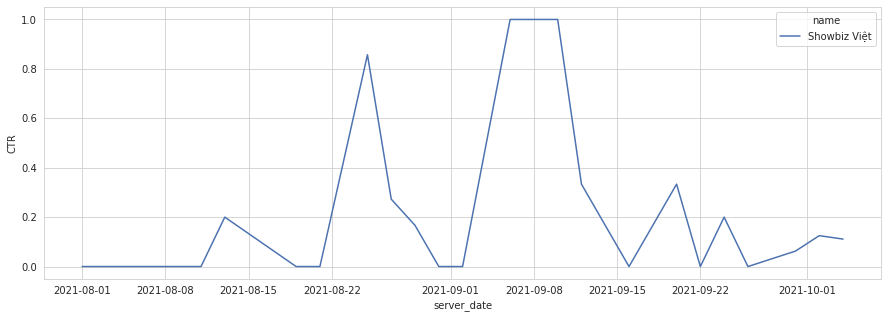

In [117]:
plt.figure(figsize=(15,5))
sns.lineplot(data=user_50[user_50.name == 'Showbiz Việt'], 
             x='server_date',y='CTR', hue = 'name')

### Phân tích sâu hơn về một số user click tin Showbiz Việt

### Sau khi quan sát một số user ở dưới:
- User_12 click khá nhiều tin về từ thiện, Phi Nhung
- User_99 có xu hướng click nhiều tin có chứa tên người nổi tiếng như Hồ Ngọc Hà, Phi Nhung và ít click các tin về Jack
- User_50 click khá nhiều tin về Đàm Vĩnh Hưng và Phi Nhung vào nhiều ngày khác nhau

Có thể đang có sự khác biệt về sở thích giữa các user này

In [118]:
#User này click vào những tin nào
cat_user_12[cat_user_12.event_id ==2 ][cat_user_12.name =='Showbiz Việt'][['event_id','sapo','server_date']]

/data/dataanalyst/anaconda3/envs/data_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



event_id                                               sapo  \
1336585         2  Thông tin ca sĩ Phi Nhung nhiễm Covid-19 khiến...   
2062322         2  Tin đồn Hoài Linh bí mật về Mỹ sau ồn ào chấn ...   
2309260         2  Những ồn ào xoay quanh quanh Thuỷ Tiên vẫn chư...   
2337215         2  Chiều 21-9, ca sĩ Đàm Vĩnh Hưng xác nhận thông...   
2372161         2  Nam ca sĩ cùng Hoài Linh và 3 nghệ sĩ khác vừa...   
2381105         2  Đàm Vĩnh Hưng từng khẳng định sẽ nhờ kiểm toán...   
2430493         2  Khi được hỏi về việc Hoài Linh rút đơn kiện nữ...   
2502054         2  Nhiều người dân vui mừng khi TP HCM thông tin ...   
2530421         2  Tài khoản từ thiện chỉ bao gồm 4 số dễ nhớ, đặ...   
2530423         2  Tài khoản từ thiện chỉ bao gồm 4 số dễ nhớ, đặ...   
2530424         2  Tài khoản từ thiện chỉ bao gồm 4 số dễ nhớ, đặ...   
2608529         2  Bài đăng mới nhất của Trấn Thành lại khiến anh...   
2608532         2  Bài đăng mới nhất của Trấn Thành lại khiến anh...   
2611720         2  Sau khi thông tin nữ ca sĩ Phi Nhung qua đời, ...   
2621727         2  HHT - Đại diện của Phi Nhung cho biết đáng lẽ ...   
2622513         2  SVVN - Nghe một người thân của Phi Nhung kể lạ...   
2624242         2  Anh Đỗ Quang Chí - quản lý truyền thông của Ph...   
2632302         2  "Bà mẹ ba con" Trương Bá Chi hiện khá bận rộn ...   
2639303         2  Trong buổi livestream vào tối ngày 28/9, b...   
2649997         2  Rất nhiều phát ngôn của đại gia Bình Dương nga...   
2676980         2  Hiện tại, Trấn Thành vẫn chưa lên tiếng về thô...   
2711602         2  Một người anh thân thiết của Phi Nhung đã tiết...   
2736497         2  Theo Thúy Nga, đây là kỷ niệm khiến cô không t...   
2744164         2  Những khoảnh khắc thân thiết bên Ngọc Trinh đư...   
2744167         2  Những khoảnh khắc thân thiết bên Ngọc Trinh đư...   

        server_date  
1336585  2021-08-27  
2062322  2021-09-11  
2309260  2021-09-20  
2337215  2021-09-21  
2372161  2021-09-22  
2381105  2021-09-22  
2430493  2021-09-24  
2502054  2021-09-26  
2530421  2021-09-26  
2530423  2021-09-26  
2530424  2021-09-26  
2608529  2021-09-28  
2608532  2021-09-28  
2611720  2021-09-28  
2621727  2021-09-28  
2622513  2021-09-28  
2624242  2021-09-28  
2632302  2021-09-29  
2639303  2021-09-29  
2649997  2021-09-29  
2676980  2021-09-30  
2711602  2021-10-01  
2736497  2021-10-01  
2744164  2021-10-01  
2744167  2021-10-01

In [119]:
cat_user_50[cat_user_50.event_id ==2 ][cat_user_50.name =='Showbiz Việt'][['event_id','sapo','server_date']]

/data/dataanalyst/anaconda3/envs/data_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



event_id                                               sapo  \
634447          2  Sau khi ghi nhận một nữ nhân viên ngân hàng dư...   
1256041         2  Ngã ngửa với lý do Đoàn Văn Hậu bị lôi vào cuộ...   
1259885         2  Một netizen còn đếm chính xác rằng đoạn clip Đ...   
1261768         2  Hình ảnh Đàm Vĩnh Hưng kiệt sức trên giường bệ...   
1278136         2  Sau màn tuyên bố sở hữu gần 2kg giấy tờ sao kê...   
1304289         2  Đàm Vĩnh Hưng tuyên chiến với bà Phương Hằng s...   
1305141         2  Đàm Vĩnh Hưng khẳng định bị bà Phương Hằng vu ...   
1405633         2  Mới đây, trên trang Facebook của trợ lý, bà Ph...   
1410753         2  Thông tin Đàm Vĩnh Hưng nhập viện trong tình t...   
1416522         2  Phi Nhung , nhạc sĩ Đào Trọng Thịnh, Lữ Đắc Lo...   
1489684         2  Trước thông tin rằng nữ nghệ sĩ đòi thu tiền m...   
1762402         2  Công Vinh tiếp tục có động thái mới nhằm bảo v...   
1819420         2  Sau khi bị một nữ doanh nhân “livestream” chỉ ...   
1996744         2  "Người ta cần lắm mới làm vậy, nhưng chỉ sợ có...   
2073275         2  Cậu IT ngầm tuyên bố sẽ chịu trách nhiệm nếu n...   
2346554         2  Ngay sau khi đơn tố cáo của Đàm Vĩnh Hưng được...   
2455675         2  Cộng đồng mạng lan truyền thông tin nữ ca sĩ T...   
2707220         2  Các con nuôi của cố ca sĩ Phi Nhung được sư th...   
2781608         2  Dù chọn im hơi lặng tiếng sau ồn ào từ thiện n...   
2871038         2  Phía FC Thủy Tiên gửi lời cảm ơn tỉnh Quảng Ng...   

        server_date  
634447   2021-08-13  
1256041  2021-08-25  
1259885  2021-08-25  
1261768  2021-08-25  
1278136  2021-08-26  
1304289  2021-08-26  
1305141  2021-08-26  
1405633  2021-08-28  
1410753  2021-08-28  
1416522  2021-08-28  
1489684  2021-08-30  
1762402  2021-09-04  
1819420  2021-09-06  
1996744  2021-09-10  
2073275  2021-09-12  
2346554  2021-09-21  
2455675  2021-09-24  
2707220  2021-09-30  
2781608  2021-10-03  
2871038  2021-10-05

In [120]:
cat_user_99[cat_user_99.event_id ==2 ][cat_user_99.name =='Showbiz Việt'][['event_id','sapo','server_date']]

/data/dataanalyst/anaconda3/envs/data_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



event_id                                               sapo  \
1776032         2  Phương Mỹ Chi tiết lộ, cô cùng gia đình vừa tr...   
1799630         2  Biểu cảm của Leon và Lisa khi ở gần nhau vô cù...   
1810811         2  Không chỉ xin lỗi, Noo Phước Thịnh đồng thời x...   
1825799         2  "Anh ấy ly dị gần 2 năm rồi, giữa hai người họ...   
1838314         2  Hành động chu đáo và cẩn thận của vợ chồng Lý ...   
1847900         2  Showbiz 6/9: Công Vinh chính thức lên tiếng về...   
1862900         2  “Đến bao giờ thì một số người mới có thể bắt k...   
1912874         2  Lúc trước nghe nhiều người cảnh báo rằng bà ch...   
2017136         2  Chồng nói tôi bán mảnh đất bố mẹ cho làm của h...   
2024484         2  Tôi cưới chồng tôi bây giờ khi vừa trải qua mộ...   
2024485         2  Tôi cưới chồng tôi bây giờ khi vừa trải qua mộ...   
2158074         2  Trước sự ngỡ ngàng của tôi, chồng lại lạnh lùn...   
2176828         2  Hôn nhân 5 năm của chúng tôi chỉ có vất vả chứ...   
2241719         2  Gia đình hai ông bà Ân đều thuộc dạng khá giả....   
2305058         2  Giữ đúng lời hứa, Công Vinh và Thuỷ Tiên có mặ...   
2305844         2  “Không ai có thể cáo bạch tài chính chỉ bằng m...   
2306777         2  Ca sĩ người dân tộc Ba Na đã được chuyển nhập ...   
2342562         2  Tôi thất thần ôm con về lại nhà chồng. Cảm giá...   
2369534         2  Người ta nói hôn nhân là quả ngọt của tình yêu...   
2387213         2  Đề nghị của mẹ chồng khiến vợ chồng con trai l...   
2497180         2  Lùm xùm tình ái đã gây ảnh hưởng trực tiếp đến...   
2527686         2  Chỉ còn chưa đầy 2 tháng nữa, Leon và Lisa nhà...   
2567152         2  Chuyên gia trang điểm Nhật Bình tiết lộ, con g...   
2587504         2  Phi Nhung đã qua đời sau thời gian chống chọi ...   
2609471         2  1 ngày trước khi trút hơi thở cuối cùng, Phi N...   
2641214         2  Mới đây, những khoảnh khắc cuối cùng của Phi N...   
2643951         2  "Người trả xong rồi nợ trần ai/Nhẹ nhàng thanh...   
2659089         2  “Em không thể tin được điều này sẽ xảy ra. Em ...   
2662489         2  Ở những khoảnh khắc cuối đời, Phi Nhung vẫn mộ...   
2694776         2  Nghe thông tin từ BV Chợ Rẫy về quá trình điều...   
2756545         2  Nhiều đồng nghiệp đã gửi vòng hoa, đến thắp hư...   
2778706         2  Quách Tuấn Du sau khi có kết quả âm tích với S...   
2779084         2  Lễ tưởng niệm ca sĩ Phi Nhung sẽ không được tổ...   
2787084         2  Một nguồn tin thân cận tiết lộ với Thanh Niên ...   

        server_date  
1776032  2021-09-04  
1799630  2021-09-05  
1810811  2021-09-05  
1825799  2021-09-06  
1838314  2021-09-06  
1847900  2021-09-06  
1862900  2021-09-07  
1912874  2021-09-07  
2017136  2021-09-10  
2024484  2021-09-10  
2024485  2021-09-10  
2158074  2021-09-15  
2176828  2021-09-15  
2241719  2021-09-17  
2305058  2021-09-20  
2305844  2021-09-20  
2306777  2021-09-20  
2342562  2021-09-21  
2369534  2021-09-22  
2387213  2021-09-22  
2497180  2021-09-25  
2527686  2021-09-26  
2567152  2021-09-27  
2587504  2021-09-28  
2609471  2021-09-28  
2641214  2021-09-29  
2643951  2021-09-29  
2659089  2021-09-29  
2662489  2021-09-29  
2694776  2021-09-30  
2756545  2021-10-02  
2778706  2021-10-03  
2779084  2021-10-03  
2787084  2021-10-03

### Sự khác biệt giữa các user đối với từng category

In [121]:
all_user['Mean CTR'] = all_user.drop(columns = {'server_date'}).mean(axis=1)

In [122]:
#Mean and standard deviation of CTR
all_user.groupby('name').mean()[['Mean CTR','std']].sort_values('std',ascending = False)

event_id                 Mean CTR       std
name                                       
Tình yêu                 0.342536  0.417784
Nóng trên mạng           0.320954  0.405162
Showbiz Việt             0.305872  0.333808
Bóng đá                  0.205009  0.322094
Các bệnh thường gặp      0.210268  0.320185
Thế giới doanh nhân      0.198617  0.316648
Bên lề Thể thao          0.171658  0.306091
Nuôi con                 0.173431  0.303937
Game                     0.181948  0.302697
Âm nhạc                  0.167443  0.298005
Quân sự                  0.167425  0.297039
Sao quốc tế              0.188648  0.295600
Ô tô xe máy              0.160574  0.292740
Thế giới                 0.210361  0.288900
Bất động sản             0.162919  0.278195
An ninh trật tự          0.241390  0.277921
Xã hội                   0.204472  0.277692
Điện ảnh                 0.150538  0.274610
Tư vấn luật              0.130775  0.273693
Du lịch                  0.135711  0.272992
Tài chính - ngân hàng    0.117364  0.251362
Thị trường               0.137380  0.251211
Hài hước                 0.187498  0.250413
Nhà đẹp                  0.136629  0.250402
Tin thời trang           0.130960  0.236019
Dinh dưỡng               0.115963  0.232025
Hình sự                  0.114244  0.231453
Chuyện Lạ                0.100748  0.223933
Đột phá y học            0.101610  0.219540
Du học                   0.099515  0.215771
Gương mặt trẻ nổi bật    0.095356  0.207791
Quizz - Tử vi            0.115822  0.205880
Khoa học                 0.084437  0.201783
Thiết bị di động         0.089091  0.200021
Làm đẹp                  0.102567  0.199319
Rèn luyện thể chất       0.095858  0.170956
Hồ sơ vụ án              0.094819  0.164662
Mặc đẹp                  0.085574  0.149354
Lịch sử                  0.093156  0.146957
Ẩm thực                  0.076443  0.146214
Ngoai ngu                0.068654  0.124473
Viễn thông - internet    0.052320  0.122889
Quần Vợt                 0.046852  0.092703
Mua sắm - tiêu dùng      0.055370  0.091784
Chứng khoán              0.026329  0.083761
PC/đồ chơi số            0.023593  0.045723
Câu chuyện doanh nghiệp  0.002741  0.006988
Xu hướng                 0.041667  0.000000
Có thể bạn chưa biết     0.000000       NaN

### Mô tả:
 - Table trên thể hiện CTR trung bình và Standard deviation của các user theo từng category.
 - CTR càng cao thì nghĩa là category đó càng hấp dẫn user click.
 - Std càng cao nghĩa là sự phân hóa về sở thích của user với chuyên mục đó càng cao.
 
### Đánh giá:
- Nhóm 1: Category Tình yêu, Nóng trên mạng và Showbiz Việt là các category có CTR và std cao. Vì vậy, các category này rất thu hút user nhưng sở thích của user với những category này cũng có nhiều khác nhau. User đã quan tâm và click vào bài viết có từ khóa nào đó (Từ thiện, tên người nổi tiếng,...) sẽ có thể có khả năng click vào từ khóa đó cao hơn trong tương lai giống như phân tích cá nhân hóa ở trên.
- Nhóm 2: ANTT, Thế giới, Xã hội là nhóm có CTR khá cao và Str trung bình. Điều này thể hiện sự phân hóa về sở thích của user ở nhóm này thấp hơn nhóm 1. CTR ở cate này vẫn khá cao, vì vậy có thể user sẽ có tỷ lệ click cao hơn ở các tin nhận được nhiều click từ các user khác.
- Nhóm 3: Bóng đá, Các bệnh thường gặp, Thế giới doanh nhân,... là các nhóm có CTR và std khá cao. Giống như nhóm 1 nhưng các in ở nhóm này ít được user quan tâm hơn và vẫn có sự phân hóa sở thích giữa các user. Có khả năng user đã click vào bài thuộc đội bóng, bệnh hoặc doanh nhân nào đó sẽ có khả năng click vào bài viết có từ khóa đó trong tương lai.
- Nhóm 4: Một số cate có CTR và std thấp; đây là nhóm user thường bỏ qua bài viết một cách thường xuyên và ổn định

### Giải pháp:
- Nên để user tiếp cập với các post theo sở thích cá nhân của user với các post có cate thuộc nhóm 1 và 3.
- Nên cho user tiếp cận với các tin được nhiều user khác click với các tin thuộc nhóm 2 và 1.

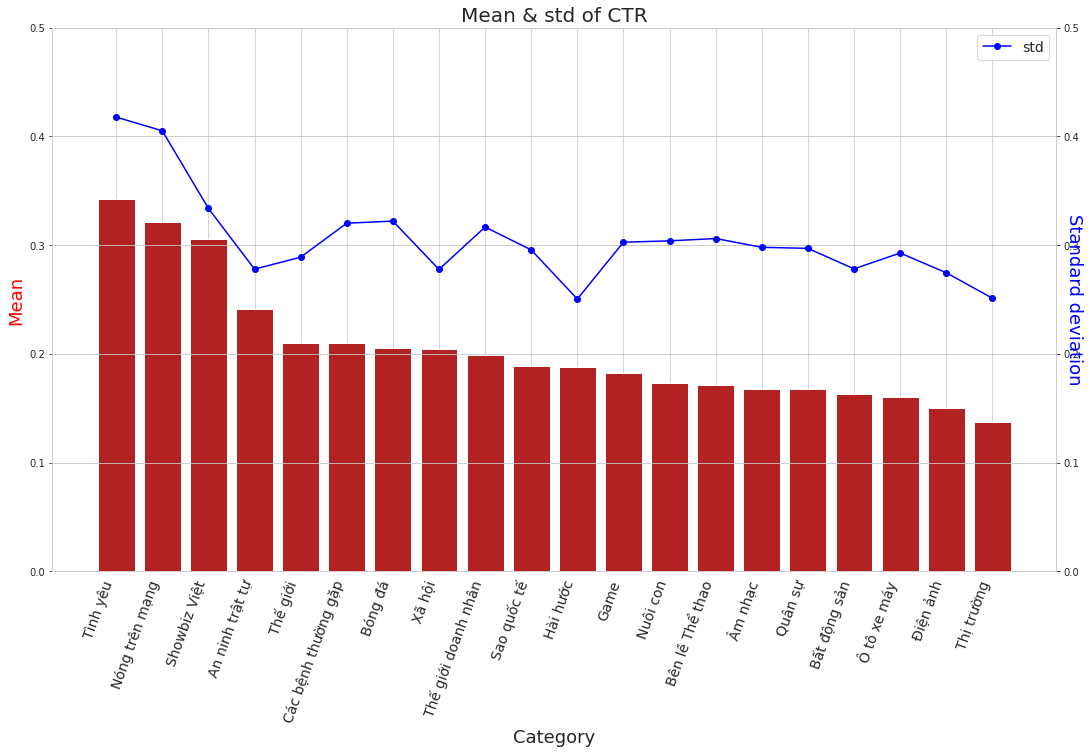

In [123]:
#visualize top 20 category
df_seen = all_user.groupby('name').mean()[['Mean CTR','std']].sort_values('Mean CTR',ascending = False).head(20)
fig,ax = plt.subplots(figsize = (18, 10))
plt.title ('Mean & std of CTR', fontsize = 20)
plt.xticks(rotation=70, ha='right',fontsize = 14)
ax.bar(df_seen.index,'Mean CTR', data=df_seen, color="firebrick")
ax.yaxis.grid(True)
ax.set_xlabel("Category",fontsize=18)
ax.set_ylabel("Mean",color="red",fontsize=18)
ax.set_ylim()
ax.set_ylim(0,0.5)
ax2=ax.twinx()
ax2.plot(df_seen.index,'std', data=df_seen,color="blue",marker="o")
ax2.set_ylabel("Standard deviation",color="blue",fontsize=18,rotation=270)
ax2.set_ylim(0,0.5)
ax2.legend(loc='upper right',fontsize=14)

plt.show()

### Source

In [44]:
source_user = origin.groupby(['device_id','name','event_id' ,pd.Grouper(key='server_date', freq='2D')]).count()[['item_id']]\
.reset_index().pivot_table(values='item_id', index=['device_id','name','server_date'],columns=['event_id']).reset_index()\
.rename(columns = {2:'click', 4 : 'close', 14 : 'sapo', 22:'surf'}).fillna(0)
source_user['CTR'] = source_user.click/(source_user.click+ source_user.sapo+ source_user.surf)

In [45]:
items_source = origin.groupby(['source']).nunique()[['item_id']]
click_source = origin[origin.event_id == 2].groupby(['source']).count()[['event_id']].rename(columns = {'event_id':'click'})
items_click = origin[origin.event_id == 2].groupby(['source']).nunique()[['item_id']].rename(columns = {'item_id':'item_click'})
click_items = click_source.merge\
(items_source, how = 'inner', on = 'source').merge(items_click, how = 'inner', on = 'source')
click_items['click_items'] = click_items.click/click_items.item_id
sapo_source = origin[origin.event_id == 14].groupby(['source']).count()[['event_id']].rename(columns = {'event_id':'sapo'})
items_sapo = origin[origin.event_id == 14].groupby(['source']).nunique()[['item_id']].rename(columns = {'item_id':'item_sapo'})
sapo_items = sapo_source.merge(items_source, how = 'inner', on = 'source').merge(items_sapo, how = 'inner', on = 'source')
sapo_items['sapo_items'] = sapo_items.sapo/sapo_items.item_id
surf_source = origin[origin.event_id ==22].groupby(['source']).count()[['event_id']].rename(columns = {'event_id':'surf'})
items_surf = origin[origin.event_id == 22].groupby(['source']).nunique()[['item_id']].rename(columns = {'item_id':'item_surf'})
surf_items = surf_source.merge(items_source, how = 'inner', on = 'source').merge(items_surf, how = 'inner', on = 'source')
surf_items['surf_items'] = surf_items.surf/surf_items.item_id
source_df = click_items.merge(sapo_items , how = 'inner', on = ['source','item_id']).merge(surf_items , how = 'inner', on = ['source','item_id'])
source_df['CTR'] = source_df.click/(source_df.sapo + source_df.surf+source_df.click)
source_df['Read_sapo_rate'] = source_df.sapo/(source_df.sapo + source_df.surf+source_df.click)
source_df['clicked_items'] = source_df.item_click/source_df.item_id

In [51]:
pivot_user = origin.groupby(['device_id','source','event_id' ,pd.Grouper(key='server_date', freq='2D')]).count()[['item_id']]\
.reset_index().pivot_table(values='item_id', index=['device_id','source','server_date'],columns=['event_id']).reset_index()\
.rename(columns = {2:'click', 4 : 'close', 14 : 'sapo', 22:'surf'}).fillna(0)
pivot_user['CTR'] = pivot_user.click/(pivot_user.click+ pivot_user.sapo+ pivot_user.surf)

In [52]:
for i in range(100):
    globals()['source_%s' % i] = pivot_user[pivot_user.device_id == user_active.device_id[i]]#.pivot_table(values='CTR', index=['device_id','name'],columns=['server_date'])
    globals()['sour_user_%s' % i] = origin[origin.device_id == globals()['source_%s' % i].reset_index().device_id[0]]\
    .drop(columns = {'is_temp', 'following_cate','following_site','content_type','description','publish_day','title_token','sapo_token','aspect_id', 'trend_id','id' })

In [57]:
source_user = source_1[['source','server_date','CTR']].rename(columns = {'CTR':f'user_0'})
for i in range(2,100):
    source_user = source_user.merge(globals()['source_%s' % i][['source','server_date','CTR']].rename(columns = {'CTR':f'user_{i}'})
                   ,on=['source','server_date'], how='outer')

In [64]:
std1 = source_user.set_index(['server_date']).drop(columns = {'source'}).transpose().std()
source_user['std'] = std1.tolist()

In [124]:
source_user['Mean CTR'] = source_user.drop(columns = {'server_date'}).mean(axis=1)

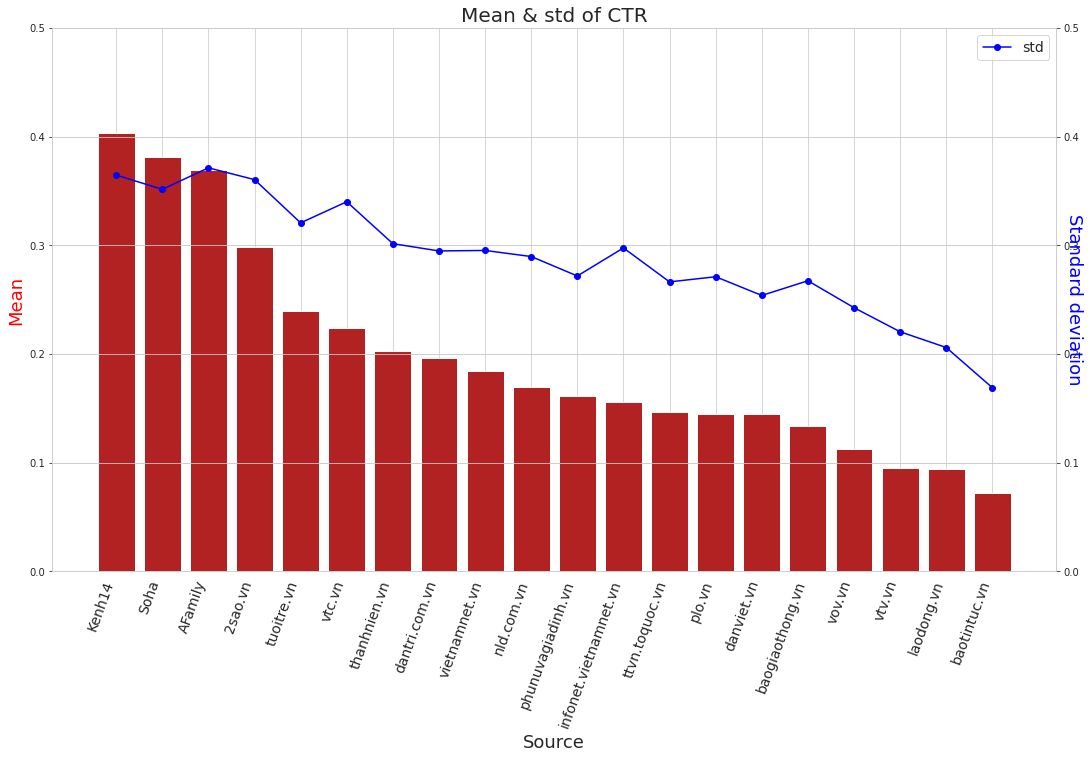

In [125]:
#visualize top 20 category
df_seen = source_user.groupby('source').mean()[['Mean CTR','std']].merge(source_df[['click']],how = 'inner', on = 'source').sort_values('click',ascending = False)\
.head(20).sort_values('Mean CTR',ascending = False)
fig,ax = plt.subplots(figsize = (18, 10))
plt.title ('Mean & std of CTR', fontsize = 20)
plt.xticks(rotation=70, ha='right',fontsize = 14)
ax.bar(df_seen.index,'Mean CTR', data=df_seen, color="firebrick")
ax.yaxis.grid(True)
ax.set_xlabel("Source",fontsize=18)
ax.set_ylabel("Mean",color="red",fontsize=18)
ax.set_ylim()
ax.set_ylim(0,0.5)
ax2=ax.twinx()
ax2.plot(df_seen.index,'std', data=df_seen,color="blue",marker="o")
ax2.set_ylabel("Standard deviation",color="blue",fontsize=18,rotation=270)
ax2.set_ylim(0,0.5)
ax2.legend(loc='upper right',fontsize=14)

plt.show()

In [135]:
df_seen['CV'] = df_seen['std']/df_seen['Mean CTR']

- Có thể nhìn thấy khá rõ xu hướng đồng biến của CTR và Std 
- Các source có CTR cũng là những source mà sở thích của user có độ phân hóa cao, nên tùy chỉnh theo sở thích user với các post thuộc những source này.